In [1]:
library(readr)
library(dplyr)
library(randomForest)
library(Hmisc)
library(party)
library(data.table)
library(ggplot2)
library(plyr)
library(dplyr)
library(corrplot)
library(pROC)
library(glmnet)
library(caret)
library(Rtsne)
library(doMC)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zo

In [2]:
data <- read.csv("creditcard.csv")


In [3]:
data$Class <- factor(data$Class)


In [4]:
index <- sample(2,nrow(data),prob = c(0.7,0.3),replace = TRUE)


In [5]:
train <- data[index==1,]
test <- data[index==2,]

In [6]:
table(train$Class)
table(test$Class)


     0      1 
198930    345 


    0     1 
85385   147 

In [7]:
library("ROSE")

Loaded ROSE 0.0-3



In [8]:
library("rpart")


Attaching package: 'rpart'

The following object is masked from 'package:survival':

    solder



In [9]:
data.rose <- ROSE(Class ~ ., data = train, seed = 1,N = 40000)$data
table(data.rose$Class)


    0     1 
20086 19914 

In [10]:
rfModel_rose <- randomForest(Class ~ . , data = data.rose)


In [11]:
rfModel_rose


Call:
 randomForest(formula = Class ~ ., data = data.rose) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 0.36%
Confusion matrix:
      0     1  class.error
0 19961   125 0.0062232401
1    19 19895 0.0009541026

In [12]:
test$predicted <- predict(rfModel_rose, test, type = 'class')


In [13]:
library(caret)
confusionMatrix(test$Class, test$predicted)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 85180   205
         1    21   126
                                         
               Accuracy : 0.9974         
                 95% CI : (0.997, 0.9977)
    No Information Rate : 0.9961         
    P-Value [Acc > NIR] : 5.458e-10      
                                         
                  Kappa : 0.5261         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9998         
            Specificity : 0.3807         
         Pos Pred Value : 0.9976         
         Neg Pred Value : 0.8571         
             Prevalence : 0.9961         
         Detection Rate : 0.9959         
   Detection Prevalence : 0.9983         
      Balanced Accuracy : 0.6902         
                                         
       'Positive' Class : 0              
                                         

In [14]:
library(MLmetrics)



Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall



In [15]:
F1_all <- F1_Score(test$Class, test$predicted)
F1_all

[1] 0.9986752

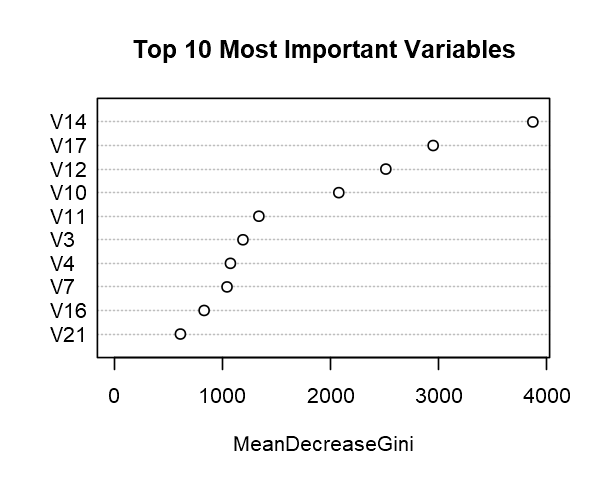

In [16]:
options(repr.plot.width=5, repr.plot.height=4)
    varImpPlot(rfModel_rose,
          sort = T,
           n.var=10,
           main="Top 10 Most Important Variables")

In [17]:
rfModelTrim1 <- randomForest(Class ~  V14, 
                            data = data.rose)

test$predictedTrim1 <- predict(rfModelTrim1, test)

F1_1 <- F1_Score(test$Class, test$predictedTrim1)
F1_1

[1] 0.9307968

In [18]:
rfModelTrim2 <- randomForest(Class ~  V14 + V17, 
                            data = data.rose)

test$predictedTrim2 <- predict(rfModelTrim2, test)

F1_2 <- F1_Score(test$Class, test$predictedTrim2)
F1_2

[1] 0.9930496

In [19]:
rfModelTrim3 <- randomForest(Class ~  V17 + V10 + V14, 
                            data = data.rose)

test$predictedTrim3 <- predict(rfModelTrim3, test)

F1_3 <- F1_Score(test$Class, test$predictedTrim3)
F1_3

[1] 0.9951762

In [20]:
# four variables
rfModelTrim4 <- randomForest(Class ~  V17 + V12 + V14 + V10, 
                            data = data.rose)

test$predictedTrim4 <- predict(rfModelTrim4, test)

F1_4 <- F1_Score(test$Class, test$predictedTrim4)
F1_4

[1] 0.9968227

In [21]:
# five variables
rfModelTrim5 <- randomForest(Class ~  V17 + V12 + V14 + V10 + V3, 
                            data = data.rose)

test$predictedTrim5 <- predict(rfModelTrim5, test)

F1_5 <- F1_Score(test$Class, test$predictedTrim5)
F1_5

[1] 0.9973292

In [22]:
# ten variables
rfModelTrim10 <- randomForest(Class ~  V17 + V12 + V14 + V10 + V16 
                              + V11 + V8 + V4 + V18 + V3, 
                            data = data.rose)

test$predictedTrim10 <- predict(rfModelTrim10, test)

F1_10 <- F1_Score(test$Class, test$predictedTrim10)
F1_10

[1] 0.9980702

In [23]:
# build dataframe of number of variables and scores
numVariables <- c(1,2,3,4,5,10,17)
F1_Score <- c(F1_1, F1_2, F1_3, F1_4, F1_5, F1_10, F1_all)
variablePerf <- data.frame(numVariables, F1_Score)

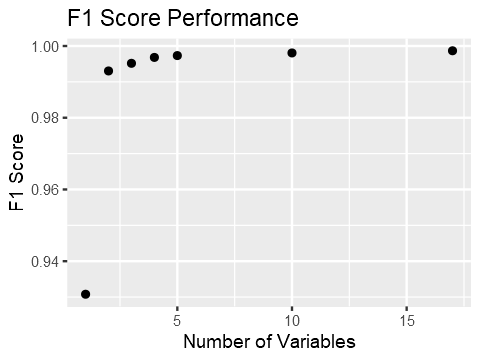

In [24]:
# plot score performance against number of variables
options(repr.plot.width=4, repr.plot.height=3)
ggplot(variablePerf, aes(numVariables, F1_Score)) + geom_point() + labs(x = "Number of Variables", y = "F1 Score", title = "F1 Score Performance")

Area under the curve (AUC): 0.927

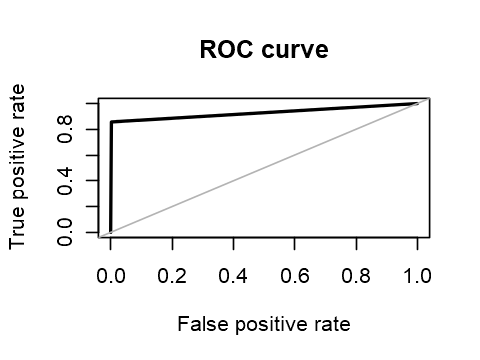

In [28]:
roc.curve(test$Class, test$predicted, plotit = T)
